# <center> Comparisons experiments of XSDC with semi-supervised k-means </center>

In this notebook, we present comparisons of XSDC with usual baseline for semisupervised 
The baseline algorithm for unsupervised learning is k-means.
When considering data with labeled and unlabeled data, k-means can be modified
by using seeds leading to Seeded K-means presented by [1]. In this notebook, we present baseline experiments for semi-supervised learning using seeded k-means as presented in [2].

### Semi-supervised k-means
We present below the pesudo-code of the implementation
of semi-supervised k-means as done by [1].

<center><img src="img/seeded_kmeans.png" alt="Semi-Supervised k-means" width="600" /></center>

The algorithm relies on the computation
of the distance matrix from the points to the centers of the clusters,
i.e., computing $D = (D_{ik})_{\substack{i=1,\ldots, n\\ k =1, \ldots K}}$
with $D_{ik} = \|x_i - c_k\|_2$.
Denote then
- the cluster centers by $C = (c_1, \ldots, c_K)^\top \in \mathbb{R}^{K \times d}$,
- the assignment matrix of the points to the given clusters,
by $Z \in \{0,1\}^{n \times K}$ such that $Z_{ik}=1$ if and only if
point $i$ belongs to cluster $k$
- the matrix of points by $X = (x_1, \ldots, x_n)^\top \in \mathbb{R}^{n \times d}$.

The matrix D is given by
$$ D = \textrm{diag}(X X^\top)1_K^\top - 2XC^\top + 1_n \textrm{diag}(C C^\top)^\top $$
where $1_n$ denotes the vector of size $n$ composed of ones.

For a fixed assignment matrix $Z$, the centers are given
as $C = (Z^\top Z)^{-1} Z^\top X$; hence the matrix of distances
can be computed directly from the knowledge of the Gram matrix
$G= X^\top X$ and the assignment matrix $Z$.

As a consequence, we can adapt the implementation of the algorithm of [1]
to use a Gram matrix defined by any kernel. The overall algorithm is presented below.
We use $\delta_{ik}$ to denote the Kronecker delta symbol such that
$\delta_{jk} = 1$ if $j =k$ and 0  otherwise.

<center><img src="img/kernel_seeded_kmeans.png" alt="Semi-Supervised k-means with generic Gram matrix" width="600" /></center>


### Kernel choices
For the rest of the implementation, the main computational bottleneck
is the computation of the Gram matrix $G$, which we will parameterize using a kernel, namely, $G = (h(x_i, x_j))_{i,
j=1}^n$. The kernels we consider are
-  a linear kernel: $h(x, y) = x^\top y$,
which amounts to clustering points with respect to the squared Euclidean distances in the original feature space;
- a data-dependent similarity measure defined by the regularized inverse correlation matrix:
$h(x, y) = x^\top (X^\top X/(n-1) +\lambda I)^{-1} y$,
where $X= (x_1, \ldots, x_n)^\top \in \mathbb{R}^{n \times d}$
is the set of all standardized training points and $\lambda \geq 0$ is a regularization parameter;
- a non-linear similarity measure defined by a Gaussian Radial Basis Function (RBF) kernel:
$h(x, y) = \exp\left(- \|x-y\|_2^2/(2\sigma^2)\right)$ for some bandwidth parameter $\sigma>0$,
which amounts to clustering points in the reproducing kernel Hilbert space associated with $h$.

The bandwidth parameter of the RBF kernel is chosen using the median heuristic.
Namely, we choose $\sigma = \sqrt{2 d}$, where $d = \textrm{Median}((\|x_i-x_j\|_2^2)_{1\leq i<j\leq n})$
is the median squared distance computed from all data (unlabeled and labeled ones) [4].
The regularization parameter for the similarity measure based on the correlation matrix is chosen using the
heuristic $\lambda = \lambda_{\max}(C)/\mathrm{Tr}(C)$, where $C = X^\top X/(n-1)$.


### Data preprocessing
The data is selected from one of the datasets 'gisette', 'magic' or 'mnist'. Instructions on how to download them may be found in the
README file. 
The data is standardized (based on the ``scaling`` parameter in the following); see the code in the file ``get_data``.
Then the reference hyper-parameters, i.e., the bandwidth of the Gaussian kernel or the regularization
of the data-dependent kernel, are computed from the data (function ``get_hyper_params_ref``).

In [1]:
import os
import torch
import scipy.sparse.linalg as splinalg
import sys

sys.path.append('../experiments')
sys.path.append('..')


from baselines.kernels_utils import RBF
from baselines.get_data import keep_labels

from baselines.pipeline_utils import var_to_str
# The function var_to_str is a simple helper that transforms e.g.,
# a dictionary into a string to get an automatic nomenclature of the experiments

from baselines.get_data import get_full_data
# The function get_full_data(dataset, scaling, n_train)
# given in baselines.get_data, takes as inputs the name of the dataset (such as 'mnist'),
# whether the data is scaled, i.e., scaling=True or False and the number of points n_train
# to consider in the dataset. This function returns a dictionnary
# full_data = dict(train=dict(X=..., y=...), test=dict(X=..., y=...))
# where X are matrices of the data points (stacked by rows) and y are vectors of labels.

data_path = os.path.dirname(os.path.abspath(''))
data_path = os.path.split(data_path)[0]
data_path = os.path.join(data_path, 'experiments', 'baselines', 'datasets')
def get_hyper_params_ref(dataset, scaling=True):
    """
    Compute once and for all the reference hyper-parameters
    for the dataset such as the bandwidth using the median heuristic
    """
    subsample = 5
    dataset_path = os.path.join(data_path, dataset)
    data_cfg = dict(scaling=scaling)
    file_path = os.path.join(dataset_path, var_to_str(data_cfg) + '_hyper_params_ref.pt')

    if os.path.exists(file_path):
        hyperparams_ref = torch.load(open(file_path, 'rb'))
    else:
        full_data = get_full_data(dataset, scaling=scaling)
        X_train = full_data['train']['X']
        X_train = X_train[::subsample]
        del full_data

        cov = (X_train.t().mm(X_train)/len(X_train)).numpy()
        lambda_max = np.real(splinalg.eigs(cov, 1)[0])
        reg_ref = (lambda_max/np.trace(cov)).item()
        reg_ref = float('{:1.2e}'.format(reg_ref))
        print(f'reg ref: {reg_ref}')
        del cov

        dists = torch.cdist(X_train, X_train)**2
        del X_train
        dists = torch.triu(dists)
        sigma_ref = torch.sqrt(torch.median(dists[dists != 0])/2).item()
        sigma_ref = float('{:1.2e}'.format(sigma_ref))
        print(f'sigma ref: {sigma_ref}')

        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        hyperparams_ref = dict(reg_ref=reg_ref, sigma_ref=sigma_ref)
        torch.save(hyperparams_ref, open(file_path, 'wb'))
    return hyperparams_ref


Once the hyper-parameters are fixed, we compute the Gram matrices and save them for further use in ``compute_gram`` and
``preprocess_gram``. 

In [2]:
def compute_gram(X, Y, kernel='linear', reg=None, sigma=None):
    """
    Compute gram matrix between set of points
    :param X: matrix of points stacked in rows, i.e., X = (x_1,..., x_n)^T
    :param Y: matrix of points stacked in rows, i.e., Y = (y_1,..., y_n)^T
    :param kernel: choice of kernel to use
    :param sigma: bandwidth for rbf kernel
    :param reg: regularization for kernel defined by the inverse of the covariance matrix

    :return: Gram matrix of X and Y according to the chosen kernel
    """
    if kernel == 'linear':
        gram = X.mm(Y.t())
    elif kernel == 'svd':
        gram = X.mm(torch.solve(Y.t(), Y.t().mm(Y)/Y.size(0) + reg*torch.eye(Y.size(1)))[0])
    elif kernel == 'rbf':
        kernel_func = RBF(sigma)
        gram = kernel_func(X, Y)
    else:
        raise NotImplementedError
    return gram

def preprocess_gram(dataset, scaling, n_train=None, kernel='linear', reg=None, sigma=None):
    """
    Compute the Gram matrices of the train and test points in the dataset
    and save it for further use
    (e.g., if we run the same experiment but with a different number of labels)
    """
    data_cfg = dict(scaling=scaling, kernel=kernel)
    if reg is not None:
        data_cfg.update(reg=reg)
    if sigma is not None:
        data_cfg.update(sigma=sigma)
    if n_train is not None:
        data_cfg.update(n_train=n_train)
    file_path = os.path.join(data_path, dataset, var_to_str(data_cfg) + 'gram_data.pt')

    if os.path.exists(file_path):
        gram_data = torch.load(open(file_path, 'rb'))
    else:
        full_data = get_full_data(dataset, scaling, n_train)
        gram_train = compute_gram(full_data['train']['X'], full_data['train']['X'], kernel, reg, sigma)
        gram_test = compute_gram(full_data['test']['X'], full_data['train']['X'], kernel, reg, sigma)

        gram_data = dict(train=dict(gram=gram_train, y=full_data['train']['y']),
                         test=dict(gram=gram_test, y=full_data['test']['y']), n_class=full_data['n_class'])
        torch.save(gram_data, open(file_path, 'wb'))
    return gram_data


Finally the whole pipeline is given in ``get_preprocessed_data`` where part of the labels are
removed to simulate a semi-supervised learning setting.

In [3]:
def get_preprocessed_data(dataset, scaling, n_train, seed, n_labels, kernel, reg=None, sigma=None):
    """
    Compute the Gram matrices of the data with some reference hyper-parameters
    In addition remove some labels to simulate a semi-supervised setting
    """
    torch.manual_seed(seed)

    hyper_params_ref = get_hyper_params_ref(dataset, scaling)
    if kernel == 'svd' and reg is None:
        reg = hyper_params_ref['reg_ref']
    if kernel == 'rbf' and sigma is None:
        sigma = hyper_params_ref['sigma_ref']

    gram_data = preprocess_gram(dataset, scaling, n_train, kernel, reg, sigma)
    idx_labeled = keep_labels(gram_data['train']['y'], seed, n_labels)
    gram_data.update(idx_labeled=idx_labeled)
    return gram_data

### Semi-supervised k-means
The following code implements the semi-supervised k-means as presented in pseudo-code in the introduction
(see ``semi_sup_kmeans``). 

In [4]:
import numpy as np
import scipy
from sklearn.metrics import confusion_matrix

from baselines.kernels_utils import one_hot_embedding
from baselines.semi_sup_kmeans import kmeans_init

def semi_sup_kmeans(gram, labels, idx_labeled, n_clust, max_iter=50):
    """
    Implement the semi-supervised k-means algorithm with seeding.
    If there are no labels, i.e., len(idx_labeled)==0, then implement a k-means
    with k--means++ initialization

    Since we do not have access to a finite representation of the centers if we use a kernel,
    we directly plug the current solution for the centers given as
    C = (ZZ^T)^{-1}Z^T X
    The computations follow using some properties of the assignment matrix such as (ZZ^T)^{-1} = diag(Z^T 1)^{-1}
    To ensure that the known labels are well assigned, we fix them after each iteration.

    :param gram: Gram matrix
    :param labels: known labels
    :param idx_labeled: Indexes of the known labels
    :param n_clust: Number of clusters to form (a priori same as the number of classes)
    :param max_iter: Maximum number of iterations of k-means with seeding.
    :return: Z: Assignment matrix

    """
    # Initialization
    k = n_clust
    n = gram.size(0)
    if len(idx_labeled) > 0:
        known_labels = one_hot_embedding(labels[idx_labeled], k)
        n_lab, k = known_labels.size(0), known_labels.size(1)
        Z = torch.zeros(n, k)
        Z[idx_labeled] = known_labels
    else:
        Z = kmeans_init(gram, k)

    # Repeat
    for i in range(max_iter):
        if i % 10 == 5:
            norm_equiv = Z.mm(torch.diag(1 / Z.sum(dim=0)).mm(Z.t()))
            prev_obj = torch.trace((torch.eye(n) - norm_equiv)*gram)

        Z_norm = Z*(1 / Z.sum(dim=0))[:, ]
        aux = gram.mm(Z_norm)
        dists = -2*aux + torch.ones(n).ger(torch.sum(Z_norm*aux, dim=0))
        Z = one_hot_embedding(dists.argmin(dim=1), k)
        if len(idx_labeled) > 0:
            Z[idx_labeled] = known_labels

        if i % 10 == 5:
            norm_equiv = Z.mm(torch.diag(1 / Z.sum(dim=0)).mm(Z.t()))
            obj = torch.trace((torch.eye(n) - norm_equiv)*gram)
            if torch.abs(prev_obj-obj) < 1e-6:
                print('kmeans converged in {} iterations'.format(i))
                break
    return Z

Once the assignment of the training data has been computed, we can test our clusters
on new sets of data points. Note that the clusterings we obtain may not be aligned with the true labels in ``predict``.
Imagine that we found the perfect clusters. Their order, i.e., the actual number of the label,
may still differ from the true labels. To obtain a fair measure of performance,
we align the predictions with the true labels in ``align_pred_test_lab``.

In [5]:
def predict(new_gram, gram, Z):
    """
    Given a computed assignment matrix, from which clusters can be computed,
    predict the assignments of a new set of points whose Gram matrix
    with the training data is given in new_gram

    :param new_gram: Gram matrix between test and train data
    :param gram: Gram matrix of the train data
    :param Z: assignment matrix of the training data
    :return: y_pred predicted assignments for the new points
    whose Gram matrix with the train data was given in new_gram
    """
    Z_norm = Z * (1 / Z.sum(dim=0))[:, ]
    aux = gram.mm(Z_norm)
    norm_centers = torch.sum(Z_norm * aux, dim=0)

    n_new = new_gram.size(0)
    Z_norm = Z * (1 / Z.sum(dim=0))[:, ]
    dists = -2*new_gram.mm(Z_norm) + torch.ones(n_new).ger(norm_centers)
    y_pred = dists.argmin(dim=1)
    return y_pred


def align_pred_test_lab(y_pred, y_test, k):
    """
    The algorithm can assign new points to given clusters
    but the actual labels may differ, since the ordering of the clusters
    may not taken into account if there are no labels for example.
    This function realigns the numbering of the clusters such that
    it finds the most relevant numbering for the predictions

    :param y_pred: predicted labels
    :param y_test: true labels
    :param k: number of clusters

    :return: y_pred_aligned: predicted labels whose numbering
    has been reassigned to match the true numbering in the best possible way
    """
    # Relabel classes
    conf_matrix = confusion_matrix(y_test, y_pred)
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-1 * conf_matrix)

    y_pred_aligned = -1 * np.ones_like(y_pred)
    for i in range(k):
        idxs = np.where(y_pred == i)[0]
        label = np.where(col_ind == i)[0][0]
        y_pred_aligned[idxs] = int(label)
    y_pred_aligned = torch.from_numpy(y_pred_aligned.flatten())
    return y_pred_aligned

The whole algorithm is then presented in ``predict_with_semi_sup_kmeans``. It takes as inputs the Gram matrices of the data preprocessed in the previous section.

In [6]:
def predict_with_semi_sup_kmeans(data, max_iter=50):
    """
    Run semi-supervised k-means on the training data, then test it on new points

    :param: data as output from the function get_preprocessed_data
    :param: max_iter number of iterations of kmeans
    :return: accuracy on test data
    """
    # Algo
    gram_train, gram_test = data['train']['gram'], data['test']['gram']
    y_train, y_test = data['train']['y'], data['test']['y']
    idx_labeled, n_class = data['idx_labeled'], data['n_class']
    Z = semi_sup_kmeans(gram_train, y_train, idx_labeled, n_class, max_iter)

    # Predict
    y_pred = predict(gram_test, gram_train, Z)
    y_pred = align_pred_test_lab(y_pred, y_test, n_class)
    acc_test = torch.sum(y_pred == y_test).float() / len(y_pred)
    return acc_test

### Performance
We can then combine the preprocessing of the data with the actual algorithm and test our baseline on some dataset.
The following functions are simple wrappers that avoid recomputing the experiments twice.

In [7]:
from pandas import DataFrame
def exp_core(dataset, scaling=True, n_train=None, seed=0, n_labels=0,
             kernel='linear', sigma=None, reg=None, max_iter=100):
    data = get_preprocessed_data(dataset, scaling, n_train, seed, n_labels, kernel, reg, sigma)
    test_acc = predict_with_semi_sup_kmeans(data, max_iter)
    return test_acc


def wrapped_exp_core(data_cfg, optim_cfg):
    exp_cfg = dict(data_cfg=data_cfg, optim_cfg=optim_cfg)
    print(*['{0}:{1}'.format(key, value) for key, value in exp_cfg.items()], sep='\n')
    exp_path = os.path.dirname(os.path.abspath(''))
    exp_path = os.path.join(exp_path, 'experiments', 'baselines')
    file_path = os.path.join(exp_path, 'results', var_to_str(data_cfg), var_to_str(optim_cfg) + '.pt')
    if os.path.exists(file_path):
        _, test_acc = torch.load(open(file_path, 'rb'))
    else:
        test_acc = exp_core(**data_cfg, **optim_cfg)

        os.makedirs(os.path.dirname(file_path), exist_ok=True)
        torch.save([exp_cfg, test_acc], open(file_path, 'wb'))

    result = {**data_cfg, **optim_cfg}
    result.update(test_acc=test_acc.item())
    result = DataFrame(result, index=[0])
    return result


We present an example on a subset of the MNIST dataset below. Full comparisons are provided in the folder. 

data_cfg:{'dataset': 'mnist', 'seed': 0, 'scaling': True, 'n_labels': 0, 'kernel': 'linear', 'n_train': 500}
optim_cfg:{'max_iter': 100}
data_cfg:{'dataset': 'mnist', 'seed': 0, 'scaling': True, 'n_labels': 50, 'kernel': 'linear', 'n_train': 500}
optim_cfg:{'max_iter': 100}
data_cfg:{'dataset': 'mnist', 'seed': 0, 'scaling': True, 'n_labels': 100, 'kernel': 'linear', 'n_train': 500}
optim_cfg:{'max_iter': 100}
data_cfg:{'dataset': 'mnist', 'seed': 0, 'scaling': True, 'n_labels': 150, 'kernel': 'linear', 'n_train': 500}
optim_cfg:{'max_iter': 100}
data_cfg:{'dataset': 'mnist', 'seed': 0, 'scaling': True, 'n_labels': 200, 'kernel': 'linear', 'n_train': 500}
optim_cfg:{'max_iter': 100}


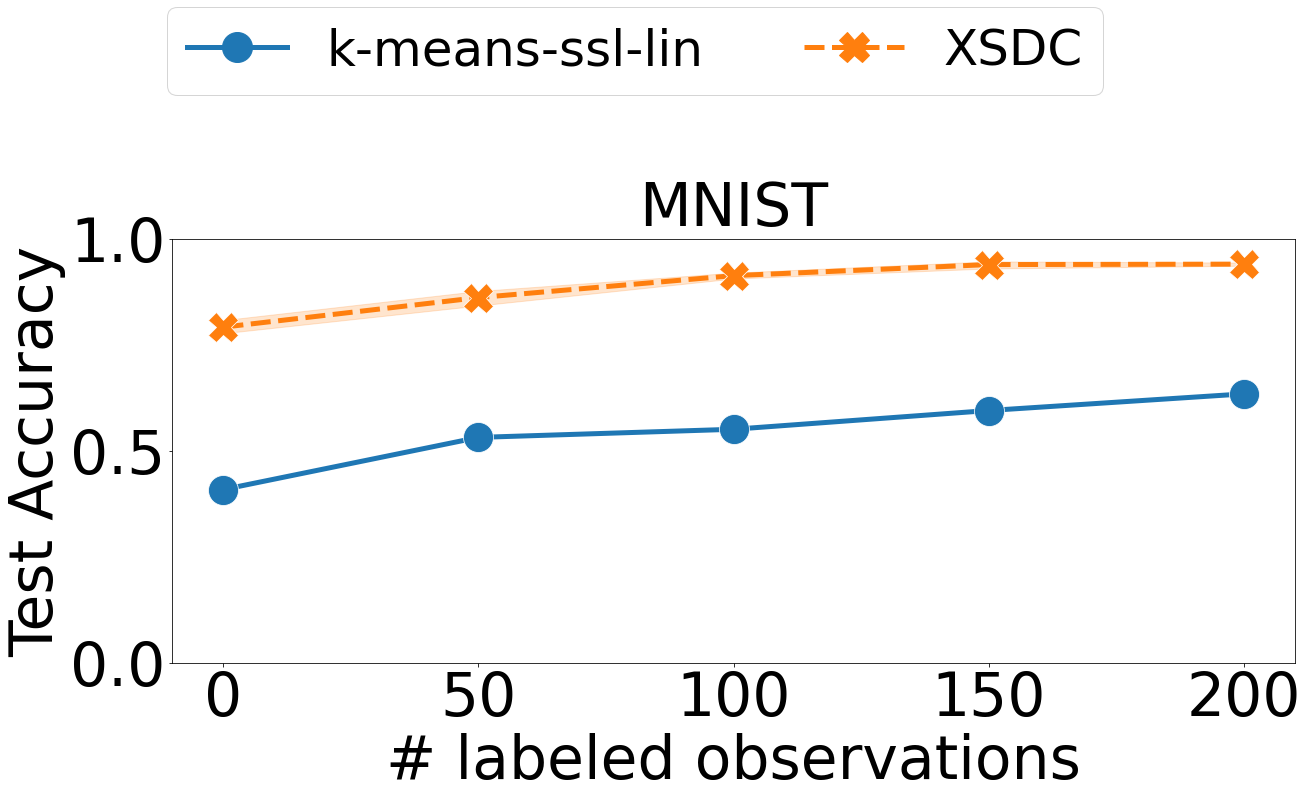

In [9]:
from baselines.pipeline_utils import build_list_exp
from baselines.plot_tools import plot_exp
dataset = 'mnist'
scaling = True
kernel = 'linear'
data_cfg = dict(dataset=dataset, seed=0, scaling=scaling,
                n_labels=[50 * i for i in range(0, 5)], kernel=kernel)
data_cfg.update(n_train=500)
optim_cfg = dict(max_iter=100)
exp_cfgs = build_list_exp([dict(data_cfg=data_cfg, optim_cfg=optim_cfg)])

results = DataFrame()
for exp_cfg in exp_cfgs:
    result = wrapped_exp_core(exp_cfg['data_cfg'], exp_cfg['optim_cfg'])
    results = results.append(result, ignore_index=True)

plot_exp(results, max_n_labels=200, add_xsdc_results=True)

We observe that our method XSDC outperforms the baseline, semi-supervised k-means, by considering a complex similarity measure based on deep networks. For more details about our method, see [2]. 

### References

[1] Basu S., Banerjee A., Mooney R. (2002) "Semi-supervised clustering by seeding".
*International Conference on Machine Learning.*  
[2] Jones, C., Roulet, V., Harchaoui, Z. (2022) "Discriminative Clustering
with Representation Learning with any Ratio of Labeled to Unlabeled Data".
*Statistics and Computing.*  
[3] LeCun Y., Cortes C. (2010) "MNIST handwritten digit database" http://yann.lecun.com/exdb/mnist/  
[4] Fukumizu K., Gretton A., Lanckriet G., Scholkopf B., Sriperumbudur B. K. (2009)
"Kernel choice and classifiability for RKHS embeddings of probability distributions".
*Advances in Neural Information Processing Systems*.